In [1]:

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import torch
import collections
from scipy.linalg import expm,norm
import glob
import open3d as o3d
import struct
import matplotlib.pyplot as plt
from tqdm import tqdm
from prettytable import PrettyTable
import time
import random


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/root/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/root/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/root/.venv/lib/python3.10/site-packages/ipykernel/kernelap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import socket
print("Running on:", socket.gethostname())

Running on: Trainmodel


<h2> Build PointNet++ </h2>

In [3]:


# helper functions:
def farthest_point_sample(xyz, npoint):
    batch_size, n, _ = xyz.shape
    device = xyz.device
    centroids = torch.zeros(batch_size, npoint, dtype=torch.long).to(device)
    distance = torch.ones(batch_size, n).to(device) * 1e10
    farthest = torch.randint(0, n, (batch_size,), dtype=torch.long).to(device)
    batch_indices = torch.arange(batch_size, dtype=torch.long).to(device)

    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].unsqueeze(1)  # [B, 1, 3]
        dist = torch.sum((xyz - centroid) ** 2, -1)  # Squared distance [B, N]
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]  # Index of the farthest point

    return centroids


def gather_points(points, idx):
    """
    points: [B, N, C]
    idx: [B, S] or [B, S, K]
    Output: [B, S, C] or [B, S, K, C]
    """
    B = points.shape[0]
    if idx.dim() == 2:
        batch_indices = torch.arange(B, dtype=torch.long, device=points.device).view(B, 1).repeat(1, idx.shape[1])
        return points[batch_indices, idx]  # [B, S, C]
    elif idx.dim() == 3:
        B, S, K = idx.shape
        C = points.shape[2]
        idx_expand = idx.unsqueeze(-1).expand(-1, -1, -1, C)
        points_expand = points.unsqueeze(1).expand(-1, S, -1, -1)
        return torch.gather(points_expand, 2, idx_expand)  # [B, S, K, C]


def query_and_group(xyz, new_xyz, points, radius, nsample):
    B, N, _ = xyz.shape
    _, npoint, _ = new_xyz.shape

    # Compute squared distances between sampled points and all points
    sqrdists = square_distance(new_xyz, xyz)  # [B, npoint, N]

    # Find indices of the nearest neighbors
    group_idx = sqrdists.argsort(dim=-1)[:, :, :nsample]  # [B, npoint, nsample]

    # Gather the grouped xyz coordinates
    grouped_xyz = gather_points(xyz, group_idx)  # [B, npoint, nsample, 3]
    grouped_xyz = grouped_xyz - new_xyz.unsqueeze(2)  # Local coordinates [B, npoint, nsample, 3]

    if points is not None:
        grouped_points = gather_points(points.transpose(1, 2), group_idx).permute(0, 3, 2, 1)  # [B, C, nsample, npoint]
        new_points = torch.cat([grouped_xyz.permute(0, 3, 2, 1), grouped_points], dim=1)  # [B, C+3, nsample, npoint]
    else:
        new_points = grouped_xyz.permute(0, 3, 2, 1)  # [B, 3, nsample, npoint]

    return new_points


def square_distance(src, dst):
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))  # [B, N, M]
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist


class SetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp):
        super(SetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample

        # Include x, y, z coordinates in the input channel count
        last_channel = in_channel + 3  # Add (x, y, z)
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))  # Conv2D expects [B, C_in, nsample, npoint]
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

    def forward(self, xyz, points):


        if self.npoint is not None:
            idx = farthest_point_sample(xyz, self.npoint)  # [B, npoint]
            new_xyz = gather_points(xyz, idx)  # [B, npoint, 3]
        else:
            new_xyz = xyz  # Use all points if npoint is None

        grouped_points = query_and_group(xyz, new_xyz, points, self.radius, self.nsample)  # [B, C+3, nsample, npoint]
        for i, conv in enumerate(self.mlp_convs):
            grouped_points = F.relu(self.mlp_bns[i](conv(grouped_points)))  # [B, out_channel, nsample, npoint]

        # Max pooling over nsample dimension
        new_points = torch.max(grouped_points, 2)[0]  # [B, mlp[-1], npoint]
        return new_xyz, new_points
    
    
class Attention(nn.Module):
    """
    Lớp self-attention cho đặc trưng điểm trong point cloud.
    Dùng sau mỗi tầng Set Abstraction để tăng hiệu suất mô hình học hình học.
    Input: [B, C, N] (batch, channel, num_points)
    Output: [B, C, N]
    """
    def __init__(self, in_channels, heads=4):
        super(Attention, self).__init__()
        self.in_channels = in_channels
        self.heads = heads
        self.dk = in_channels // heads
        assert in_channels % heads == 0, "in_channels phải chia hết cho số heads"
        self.query = nn.Conv1d(in_channels, in_channels, 1)
        self.key = nn.Conv1d(in_channels, in_channels, 1)
        self.value = nn.Conv1d(in_channels, in_channels, 1)
        self.proj = nn.Conv1d(in_channels, in_channels, 1)

    def forward(self, x):
        # x: [B, C, N]
         # x: [B, C, N]
        B, C, N = x.shape
        Q = self.query(x).view(B, self.heads, self.dk, N).permute(0, 1, 3, 2)  # [B, H, N, dk]
        K = self.key(x).view(B, self.heads, self.dk, N)                        # [B, H, dk, N]
        V = self.value(x).view(B, self.heads, self.dk, N)                      # [B, H, dk, N]

        # Compute scaled dot-product attention
        attn_scores = torch.matmul(Q, K) / (self.dk ** 0.5)  # [B, H, N, N]
        attn = torch.softmax(attn_scores, dim=-1)            # [B, H, N, N]

        out = torch.matmul(attn, V.permute(0, 1, 3, 2))       # [B, H, N, dk]
        out = out.permute(0, 1, 3, 2).contiguous().view(B, C, N)  # [B, C, N]
        out = self.proj(out)
        return out + x  # Residual connection
    
class PointNetFeaturePropagation(nn.Module):

    """ Feature Propagation layer for PointNet++.
    Input: 
        xyz1: điểm có ít đặc trưng (thường là full resolution, eg. 2048)
        xyz2: điểm có nhiều đặc trưng (đã được downsample, eg. 512)
        points1: đặc trưng xyz1 (thường là None hoặc từ FP trước đó)
        points2: đặc trưng xyz2 (output của SA)
    Output:
        features của xyz1 (nhiều điểm) sau khi được interpolate từ xyz2 """
    
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel
    
    def forward(self, xyz1, xyz2, points1, points2):
        """
        Input:
            xyz1: [B, N, 3] - target points (original/resampled)
            xyz2: [B, S, 3] - source points (from SA, usually downsampled)
            points1: [B, C1, N] - features for xyz1 (may be None)
            points2: [B, C2, S] - features for xyz2

        Return:
            new_points: [B, mlp[-1], N] 
        """
        B, N, C = xyz1.shape
        _, S, _ = xyz2.shape
        if S == 1:
            interpolated_points = points2.repeat(1, 1, N)
        else:
            # 3 nearest neighbor interpolation
            dists = square_distance(xyz1, xyz2)  # [B, N, S]
            dists, idx = dists.sort(dim=-1)  # sorted distances
            dists, idx = dists[:, :, :3], idx[:, :, :3]  # Take 3-NN

            dist_recip = 1.0 / (dists + 1e-8)  # Avoid division by 0
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm

            interpolated_points = torch.sum(gather_points(points2.transpose(1, 2), idx) * weight.unsqueeze(-1), dim=2)
            interpolated_points = interpolated_points.transpose(1, 2)  # [B, C2, N]

        if points1 is not None:
            new_points = torch.cat([interpolated_points, points1], dim=1)  # [B, C1+C2, N]
        else:
            new_points = interpolated_points  # [B, C2, N]

        for i, conv in enumerate(self.mlp_convs):
            new_points = F.relu(self.mlp_bns[i](conv(new_points)))  # [B, out, N]

        return new_points
    
class LightHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.conv1 = nn.Conv1d(in_dim, 128, 1)
        self.conv2 = nn.Conv1d(128, num_classes, 1)
        

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(num_classes)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.global_pool(x)
        x = F.relu(self.dropout1(self.bn1(self.conv1(x)))) 
        x = F.relu(self.dropout2(self.bn2(self.conv2(x))))
        x= x.squeeze(dim=-1)
        return x
    

class PointNetBackbone(nn.Module):
    def __init__(self):
        super(PointNetBackbone,self).__init__()
        
        # Set Abstraction layers
        self.sa1 = SetAbstraction(npoint=128, radius=0.2, nsample=64, in_channel=0, mlp=[32,64])
        self.sa2 = SetAbstraction(npoint=64, radius=0.4, nsample=64, in_channel=64, mlp=[64, 128])
        self.sa3 = SetAbstraction(npoint=None, radius=None, nsample=None, in_channel=128, mlp=[128,128])
        # Attention layers
        self.sa1_attention = Attention(in_channels=64, heads=4)
        self.sa2_attention = Attention(in_channels=128, heads=4)
        self.sa3_attention = Attention(in_channels=128, heads=4)
    
    def forward(self, xyz):
        batch_size, _, _ = xyz.shape

        # Hierarchical feature extraction
        l1_xyz, l1_points = self.sa1(xyz, None)  
        l1_points = self.sa1_attention(l1_points)     
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)  
        l2_points = self.sa2_attention(l2_points)
        _, l3_points = self.sa3(l2_xyz, l2_points)
        l3_points = self.sa3_attention(l3_points)
        return l3_points
        
class DetectionHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.class_head = LightHead(in_dim, num_classes)
        self.bbox_pool = nn.AdaptiveMaxPool1d(1)
        self.bbox_fc = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, features):
        class_logits = self.class_head(features)
        
        x = self.bbox_pool(features).squeeze(-1)  # [B, C]
        bbox = self.bbox_fc(x)                   # [B, 7]
        return class_logits, bbox

class PointNetPlusPlusDetection(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = PointNetBackbone()
        self.head = DetectionHead(in_dim=128, num_classes=num_classes)

    def forward(self, xyz):
        features = self.backbone(xyz)
        class_logits, bbox = self.head(features)
        return class_logits, bbox





<h2> Dataset utils </h2>

In [4]:
def extract_unique_labels(label_dir):
    unique_labels = set()
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if parts[0] == 'DontCare':
                        continue
                    unique_labels.add(parts[0])  # Add the label (Class)
    return sorted(unique_labels)

In [5]:
def bin_to_pcd(binFileName):
    size_float = 4
    list_pcd = []
    with open(binFileName, "rb") as f:
        byte = f.read(size_float * 4)
        while byte:
            x, y, z, intensity = struct.unpack("ffff", byte)
            list_pcd.append([x, y, z])
            byte = f.read(size_float * 4)
    np_pcd = np.asarray(list_pcd)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_pcd)
    return pcd

In [6]:
velodyne_dir = r"/root/data/training/velodyne"
label_dir = r"/root/data/training/label_2"
calib_dir = r"/root/data/training/calib"
unique_labels = extract_unique_labels(label_dir)
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
print("Extracted label mapping:", label_to_id)

Extracted label mapping: {'Car': 0, 'Cyclist': 1, 'Misc': 2, 'Pedestrian': 3, 'Person_sitting': 4, 'Tram': 5, 'Truck': 6, 'Van': 7}


In [7]:
def read_velodyne_bin(bin_path):
    """
    Đọc file .bin từ KITTI và trả về mảng (N, 4): x, y, z, reflectance
    """
    return np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

In [8]:
def read_kitti_label(label_file):
    """
    Đọc file .txt nhãn từ KITTI object detection.
    Trả về danh sách bounding box + class:
    [class, x, y, z, h, w, l, ry]
    """
    if not label_file.endswith('.txt'):
        return None
    boxes = []
    with open(label_file, 'r') as f:
        for line in f:
            if line.strip() == '':
                continue
            parts = line.strip().split(' ')
            cls = parts[0]
            if cls == 'DontCare':
                continue
            # Extract 3D box info
            h, w, l = map(float, parts[8:11])
            x, y, z = map(float, parts[11:14])
            ry = float(parts[14])
            boxes.append({
                'class': cls,
                'center': [x, y, z],
                'size': [l, w, h],
                'rotation': ry
            })
    return boxes

In [9]:
def read_calib_file(calib_path):
    """
    Đọc file calibration của KITTI và trả về các ma trận chuyển đổi
    """
    data = {}
    with open(calib_path, 'r') as f:
        for line in f.readlines():
            if ':' in line:
                key, value = line.split(':', 1)
                data[key] = np.array([float(x) for x in value.strip().split()])
    
    # Chuyển về ma trận đúng shape
    data['Tr_velo_to_cam'] = data['Tr_velo_to_cam'].reshape(3, 4)
    data['R0_rect'] = data['R0_rect'].reshape(3, 3)
    return data

In [10]:
def cam_to_velo(xyz_cam, calib):
    """
    Chuyển đổi tọa độ từ camera sang lidar (velodyne)
    xyz_cam: (N, 3) - tọa độ trong hệ camera
    calib: dict chứa các ma trận calibration
    """
    # Thêm 1 vào cuối để thành (N, 4) - homogeneous coordinates
    xyz_cam_hom = np.hstack([xyz_cam, np.ones((xyz_cam.shape[0], 1))])
    
    # Lấy ma trận chuyển đổi từ velodyne sang camera
    Tr = calib['Tr_velo_to_cam']  # (3, 4)
    
    # Tính ma trận nghịch đảo để chuyển từ camera sang velodyne
    Tr_inv = np.linalg.pinv(np.vstack([Tr, [0,0,0,1]]))  # (4,4)
    
    # Chuyển đổi tọa độ
    xyz_velo = (Tr_inv @ xyz_cam_hom.T).T[:, :3]
    return xyz_velo

In [11]:
def convert_3d_box_to_velo(box, calib):
    """
    Chuyển đổi 3D bounding box từ hệ camera sang hệ lidar
    box: dict chứa thông tin box {'center': [x,y,z], 'size': [l,w,h], 'rotation': ry}
    calib: dict chứa các ma trận calibration
    """
    center_cam = np.array([box['center']])  # (1, 3)
    center_velo = cam_to_velo(center_cam, calib)[0]  # (3,)
    
    # Kích thước box không đổi khi chuyển hệ tọa độ
    size_velo = box['size']  # [l, w, h]
    
    # Góc quay cần điều chỉnh (thường không đổi nhiều)
    rotation_velo = box['rotation']
    
    return {
        'center': center_velo.tolist(),
        'size': size_velo,
        'rotation': rotation_velo,
        'class': box['class']
    }

In [12]:
def extract_objects_from_pointcloud_with_calib(points, bboxes, class_map, calib):
    """
    Trích xuất object từ point cloud với chuyển đổi hệ tọa độ
    """
    objects = []
    for box in bboxes:
        cls = box['class']
        if cls not in class_map:
            continue
            
        # Chuyển đổi box từ camera sang lidar
        box_velo = convert_3d_box_to_velo(box, calib)
        
        center, size = box_velo['center'], box_velo['size']
        l, w, h = size
        x, y, z = center
        rotation = box_velo['rotation']
        # Hộp trục song song (AABB) trong hệ lidar
        mask = (
            (points[:, 0] > x - l/2) & (points[:, 0] < x + l/2) &
            (points[:, 1] > y - w/2) & (points[:, 1] < y + w/2) &
            (points[:, 2] > z - h/2) & (points[:, 2] < z + h/2)
        )
        pc_object = points[mask][:, :3]
        
        if len(pc_object) >= 30:  # Chỉ lấy object có đủ điểm
            label_id = class_map[str(cls)]
            bbox_gt = [x, y, z, l, w, h, rotation]
            objects.append((pc_object, label_id,bbox_gt))
            
    return objects

In [13]:
def extract_all_objects_with_calib(velodyne_dir, label_dir, calib_dir, class_map):
    """
    Trích xuất tất cả object từ point cloud với chuyển đổi hệ tọa độ
    """
    all_objects = []  # List chứa (pc_object, class_id)
    bin_files = sorted(glob.glob(os.path.join(velodyne_dir, "*.bin")))

    for bin_path in bin_files:
        file_id = os.path.splitext(os.path.basename(bin_path))[0]  # '000012'

        # Đường dẫn đến file label và calib tương ứng
        label_path = os.path.join(label_dir, f"{file_id}.txt")
        calib_path = os.path.join(calib_dir, f"{file_id}.txt")
        
        if not os.path.exists(label_path):
            print(f"[!] Thiếu label cho {file_id}, bỏ qua")
            continue
            
        if not os.path.exists(calib_path):
            print(f"[!] Thiếu calib cho {file_id}, bỏ qua")
            continue

        # Đọc dữ liệu
        points = read_velodyne_bin(bin_path)
        bboxes = read_kitti_label(label_path)
        calib = read_calib_file(calib_path)
        
        # Trích xuất object với chuyển đổi hệ tọa độ
        objects = extract_objects_from_pointcloud_with_calib(points, bboxes, class_map, calib)
        all_objects.extend(objects)
        
    return all_objects

<h2> Class Dataset </h2>




In [14]:
all_objs = extract_all_objects_with_calib(velodyne_dir, label_dir, calib_dir,label_to_id)

print(f"Tổng số object trích ra: {len(all_objs)}")


Tổng số object trích ra: 24709


In [15]:

def augment_pointcloud(xyz):
    xyz = xyz + (torch.randn_like(xyz) * 0.02)  # Gaussian noise

    theta = random.uniform(0, 2 * np.pi)
    R = torch.tensor([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ], dtype=xyz.dtype, device=xyz.device)

    return xyz @ R.T

In [16]:
class KittiObjectDataset(Dataset):
    def __init__(self,all_objs,num_points= 1024,augment=True) -> None:
        self.all_objs = all_objs

        self.num_points = num_points

        self.augment= augment
        
    def __len__(self):
        return len(self.all_objs)
    
    def __getitem__(self, index):
        
        pc_obj,label,bbox = self.all_objs[index]

        xyz = pc_obj[:, :3]
        xyz = torch.tensor(xyz, dtype=torch.float32)

        if self.augment:
            xyz = augment_pointcloud(xyz)
        N = xyz.shape[0]
        if N > self.num_points:
            idxs = np.random.choice(xyz.shape[0], self.num_points, replace=False)
            idxs= torch.tensor(idxs, dtype=torch.long)
        else:
            idxs = np.random.choice(xyz.shape[0], self.num_points, replace=True)
            idxs= torch.tensor(idxs, dtype=torch.long)
        
        xyz = xyz[idxs]
        bbox = torch.tensor(bbox, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return {
            "pos": xyz,                 
            "label": label, 
            "bbox": bbox
        }

In [29]:
# Training Parameters
from torch import optim
NUM_POINTS= 1024
NUM_CLASSES = len(label_to_id)
EPOCHS = 100
BATCH_SIZE = 128

# Khởi tạo mô hình detection mới

new_model = PointNetPlusPlusDetection(num_classes=NUM_CLASSES).to(device)
# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [30]:
table = PrettyTable(["Modules", "Parameters"])
total_params = 0
for name, parameter in new_model.named_parameters():
    if not parameter.requires_grad: continue
    params = parameter.numel()
    table.add_row([name, params])
    total_params+=params
print(table)
print(f"Total Trainable Params: {total_params}")

+-------------------------------------+------------+
|               Modules               | Parameters |
+-------------------------------------+------------+
|   backbone.sa1.mlp_convs.0.weight   |     96     |
|    backbone.sa1.mlp_convs.0.bias    |     32     |
|   backbone.sa1.mlp_convs.1.weight   |    2048    |
|    backbone.sa1.mlp_convs.1.bias    |     64     |
|    backbone.sa1.mlp_bns.0.weight    |     32     |
|     backbone.sa1.mlp_bns.0.bias     |     32     |
|    backbone.sa1.mlp_bns.1.weight    |     64     |
|     backbone.sa1.mlp_bns.1.bias     |     64     |
|   backbone.sa2.mlp_convs.0.weight   |    4288    |
|    backbone.sa2.mlp_convs.0.bias    |     64     |
|   backbone.sa2.mlp_convs.1.weight   |    8192    |
|    backbone.sa2.mlp_convs.1.bias    |    128     |
|    backbone.sa2.mlp_bns.0.weight    |     64     |
|     backbone.sa2.mlp_bns.0.bias     |     64     |
|    backbone.sa2.mlp_bns.1.weight    |    128     |
|     backbone.sa2.mlp_bns.1.bias     |    128

In [31]:
from torch.utils.data import random_split

dataset = KittiObjectDataset(all_objs, num_points=NUM_POINTS,augment=True)

len_dataset = len(dataset)
print(f"Tổng số mẫu trong dataset: {len_dataset}")

train_dataset, val_dataset, test_dataset = random_split(dataset,
                                          [round(0.7*len_dataset), round(0.1*len_dataset), round(0.2*len_dataset)],
                                          generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Tổng số mẫu trong dataset: 24709


In [32]:
for batch in train_dataloader:
    pos,label,bbox = batch['pos'],batch['label'],batch['bbox']
    print(pos.shape)
    print(label.shape)
    print(bbox.shape)
    break

torch.Size([128, 1024, 3])
torch.Size([128])
torch.Size([128, 7])


In [34]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
best_loss= np.inf
def training_loop(epochs, model, train_loader, criterion_cls, criterion_bbox,scheduler=None,alpha=1.0, beta=1.0):
    """
    Hàm huấn luyện mô hình PointNet++ với dữ liệu point cloud từ KITTI.
    """
    model.train()

    for epoch in tqdm(range(epochs)):
        epoch_train_loss = []
        correct = 0
        total = 0
        for batch in train_loader:
            pos , label , bbox = batch['pos'],batch['label'],batch['bbox']
            pos= pos.to(device)
            label = label.to(device)
            bbox = bbox.to(device)
            optimizer.zero_grad()
            class_logits, bbox_preds = model(pos) 
            loss_cls = criterion_cls(class_logits, label)
            loss_bbox = criterion_bbox(bbox_preds, bbox)
            
            loss = alpha * loss_cls + beta * loss_bbox
            epoch_train_loss.append(loss.cpu().item())

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(class_logits, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
        avg_loss = np.mean(epoch_train_loss)
        epoch_acc = correct / total if total > 0 else 0

        train_loss.append(avg_loss)
        train_acc.append(epoch_acc)

        print(f"Epoch {epoch+1}: train loss: {round(avg_loss, 4)}, train acc: {round(epoch_acc, 4)}")
        if scheduler:
            scheduler.step(avg_loss)
    return train_loss, train_acc


In [35]:
train_loss, train_acc = training_loop(EPOCHS, new_model, train_dataloader, criterion_cls,criterion_bbox,scheduler)

  1%|          | 1/100 [01:32<2:32:32, 92.45s/it]

Epoch 1: train loss: 3.5672, train acc: 0.4348


  2%|▏         | 2/100 [03:33<2:58:06, 109.05s/it]

Epoch 2: train loss: 2.7376, train acc: 0.5421


  3%|▎         | 3/100 [06:44<3:57:00, 146.60s/it]

Epoch 3: train loss: 2.4682, train acc: 0.6509


  4%|▍         | 4/100 [10:21<4:39:10, 174.48s/it]

Epoch 4: train loss: 2.2892, train acc: 0.7149


  5%|▌         | 5/100 [12:46<4:19:19, 163.78s/it]

Epoch 5: train loss: 2.1662, train acc: 0.7452


  6%|▌         | 6/100 [16:38<4:52:54, 186.97s/it]

Epoch 6: train loss: 2.0657, train acc: 0.7598


  7%|▋         | 7/100 [20:44<5:19:51, 206.36s/it]

Epoch 7: train loss: 2.0106, train acc: 0.7638


  8%|▊         | 8/100 [21:42<4:03:57, 159.10s/it]

Epoch 8: train loss: 1.9488, train acc: 0.7627


  9%|▉         | 9/100 [22:39<3:12:54, 127.20s/it]

Epoch 9: train loss: 1.9003, train acc: 0.7694


 10%|█         | 10/100 [23:36<2:38:14, 105.49s/it]

Epoch 10: train loss: 1.8363, train acc: 0.7749


 11%|█         | 11/100 [24:33<2:14:30, 90.68s/it] 

Epoch 11: train loss: 1.8201, train acc: 0.7698


 12%|█▏        | 12/100 [25:30<1:57:54, 80.40s/it]

Epoch 12: train loss: 1.7946, train acc: 0.7692


 13%|█▎        | 13/100 [26:27<1:46:18, 73.32s/it]

Epoch 13: train loss: 1.7609, train acc: 0.7771


 14%|█▍        | 14/100 [27:24<1:38:05, 68.43s/it]

Epoch 14: train loss: 1.734, train acc: 0.7775


 15%|█▌        | 15/100 [28:22<1:32:19, 65.18s/it]

Epoch 15: train loss: 1.7137, train acc: 0.7753


 16%|█▌        | 16/100 [29:20<1:28:14, 63.03s/it]

Epoch 16: train loss: 1.6874, train acc: 0.7826


 17%|█▋        | 17/100 [30:17<1:24:43, 61.25s/it]

Epoch 17: train loss: 1.677, train acc: 0.7799


 18%|█▊        | 18/100 [31:14<1:21:52, 59.91s/it]

Epoch 18: train loss: 1.6434, train acc: 0.7878


 19%|█▉        | 19/100 [32:11<1:19:35, 58.96s/it]

Epoch 19: train loss: 1.6599, train acc: 0.7784


 20%|██        | 20/100 [33:07<1:17:46, 58.33s/it]

Epoch 20: train loss: 1.6401, train acc: 0.7808


 21%|██        | 21/100 [34:04<1:16:06, 57.80s/it]

Epoch 21: train loss: 1.6381, train acc: 0.7848


 22%|██▏       | 22/100 [35:00<1:14:39, 57.43s/it]

Epoch 22: train loss: 1.6192, train acc: 0.7902


 23%|██▎       | 23/100 [35:57<1:13:25, 57.21s/it]

Epoch 23: train loss: 1.5975, train acc: 0.7874


 24%|██▍       | 24/100 [36:54<1:12:11, 57.00s/it]

Epoch 24: train loss: 1.6036, train acc: 0.7874


 25%|██▌       | 25/100 [37:50<1:11:03, 56.85s/it]

Epoch 25: train loss: 1.5949, train acc: 0.7888


 26%|██▌       | 26/100 [38:47<1:09:58, 56.73s/it]

Epoch 26: train loss: 1.5769, train acc: 0.7961


 27%|██▋       | 27/100 [39:44<1:09:18, 56.97s/it]

Epoch 27: train loss: 1.5653, train acc: 0.7998


 28%|██▊       | 28/100 [40:41<1:08:15, 56.88s/it]

Epoch 28: train loss: 1.5685, train acc: 0.7967


 29%|██▉       | 29/100 [41:38<1:07:17, 56.87s/it]

Epoch 29: train loss: 1.5276, train acc: 0.7911


 30%|███       | 30/100 [42:36<1:06:40, 57.15s/it]

Epoch 30: train loss: 1.5532, train acc: 0.7931


 31%|███       | 31/100 [43:33<1:05:45, 57.19s/it]

Epoch 31: train loss: 1.5288, train acc: 0.7951


 32%|███▏      | 32/100 [44:30<1:04:58, 57.32s/it]

Epoch 32: train loss: 1.5381, train acc: 0.7984


 33%|███▎      | 33/100 [45:28<1:04:01, 57.34s/it]

Epoch 33: train loss: 1.5181, train acc: 0.7957


 34%|███▍      | 34/100 [46:25<1:02:58, 57.25s/it]

Epoch 34: train loss: 1.5224, train acc: 0.7936


 35%|███▌      | 35/100 [47:22<1:02:00, 57.23s/it]

Epoch 35: train loss: 1.5192, train acc: 0.7997


 36%|███▌      | 36/100 [48:19<1:00:57, 57.14s/it]

Epoch 36: train loss: 1.5058, train acc: 0.7995


 37%|███▋      | 37/100 [49:16<59:55, 57.06s/it]  

Epoch 37: train loss: 1.5087, train acc: 0.798


 38%|███▊      | 38/100 [50:13<58:59, 57.09s/it]

Epoch 38: train loss: 1.4995, train acc: 0.8029


 39%|███▉      | 39/100 [51:10<58:04, 57.12s/it]

Epoch 39: train loss: 1.4833, train acc: 0.8056


 40%|████      | 40/100 [52:08<57:11, 57.19s/it]

Epoch 40: train loss: 1.4987, train acc: 0.8048


 41%|████      | 41/100 [53:04<56:08, 57.10s/it]

Epoch 41: train loss: 1.4884, train acc: 0.8035


 42%|████▏     | 42/100 [54:01<55:08, 57.04s/it]

Epoch 42: train loss: 1.4783, train acc: 0.806


 43%|████▎     | 43/100 [54:58<54:10, 57.03s/it]

Epoch 43: train loss: 1.4782, train acc: 0.8027


 44%|████▍     | 44/100 [55:55<53:15, 57.06s/it]

Epoch 44: train loss: 1.4673, train acc: 0.8049


 45%|████▌     | 45/100 [56:52<52:16, 57.02s/it]

Epoch 45: train loss: 1.4599, train acc: 0.7983


 46%|████▌     | 46/100 [57:49<51:14, 56.94s/it]

Epoch 46: train loss: 1.4535, train acc: 0.8053


 47%|████▋     | 47/100 [58:46<50:16, 56.92s/it]

Epoch 47: train loss: 1.47, train acc: 0.803


 48%|████▊     | 48/100 [59:43<49:19, 56.91s/it]

Epoch 48: train loss: 1.4429, train acc: 0.8057


 49%|████▉     | 49/100 [1:00:40<48:20, 56.88s/it]

Epoch 49: train loss: 1.4419, train acc: 0.8076


 50%|█████     | 50/100 [1:01:37<47:30, 57.00s/it]

Epoch 50: train loss: 1.4508, train acc: 0.8105


 51%|█████     | 51/100 [1:02:35<46:48, 57.31s/it]

Epoch 51: train loss: 1.4465, train acc: 0.8031


 52%|█████▏    | 52/100 [1:03:32<45:47, 57.25s/it]

Epoch 52: train loss: 1.4301, train acc: 0.8095


 53%|█████▎    | 53/100 [1:04:30<44:54, 57.33s/it]

Epoch 53: train loss: 1.4338, train acc: 0.808


 54%|█████▍    | 54/100 [1:05:26<43:49, 57.17s/it]

Epoch 54: train loss: 1.4304, train acc: 0.8111


 55%|█████▌    | 55/100 [1:06:23<42:47, 57.06s/it]

Epoch 55: train loss: 1.4198, train acc: 0.8138


 56%|█████▌    | 56/100 [1:07:20<41:49, 57.03s/it]

Epoch 56: train loss: 1.419, train acc: 0.8127


 57%|█████▋    | 57/100 [1:08:17<40:51, 57.00s/it]

Epoch 57: train loss: 1.4356, train acc: 0.805


 58%|█████▊    | 58/100 [1:09:14<39:54, 57.02s/it]

Epoch 58: train loss: 1.4121, train acc: 0.8125


 59%|█████▉    | 59/100 [1:10:11<38:55, 56.96s/it]

Epoch 59: train loss: 1.418, train acc: 0.8119


 60%|██████    | 60/100 [1:11:09<38:10, 57.26s/it]

Epoch 60: train loss: 1.4219, train acc: 0.8117


 61%|██████    | 61/100 [1:12:06<37:12, 57.25s/it]

Epoch 61: train loss: 1.4184, train acc: 0.8127


 62%|██████▏   | 62/100 [1:13:03<36:12, 57.18s/it]

Epoch 62: train loss: 1.4251, train acc: 0.8092


 63%|██████▎   | 63/100 [1:14:00<35:16, 57.19s/it]

Epoch 63: train loss: 1.3902, train acc: 0.815


 64%|██████▍   | 64/100 [1:14:57<34:14, 57.08s/it]

Epoch 64: train loss: 1.4042, train acc: 0.8155


 65%|██████▌   | 65/100 [1:15:55<33:20, 57.16s/it]

Epoch 65: train loss: 1.4035, train acc: 0.8119


 66%|██████▌   | 66/100 [1:16:51<32:20, 57.06s/it]

Epoch 66: train loss: 1.4026, train acc: 0.8164


 67%|██████▋   | 67/100 [1:17:48<31:20, 56.99s/it]

Epoch 67: train loss: 1.384, train acc: 0.8187


 68%|██████▊   | 68/100 [1:18:46<30:27, 57.10s/it]

Epoch 68: train loss: 1.3949, train acc: 0.8135


 69%|██████▉   | 69/100 [1:19:43<29:32, 57.18s/it]

Epoch 69: train loss: 1.3896, train acc: 0.8102


 70%|███████   | 70/100 [1:20:40<28:33, 57.12s/it]

Epoch 70: train loss: 1.3943, train acc: 0.8175


 71%|███████   | 71/100 [1:21:37<27:37, 57.17s/it]

Epoch 71: train loss: 1.3688, train acc: 0.816


 72%|███████▏  | 72/100 [1:22:34<26:40, 57.16s/it]

Epoch 72: train loss: 1.379, train acc: 0.815


 73%|███████▎  | 73/100 [1:23:32<25:48, 57.35s/it]

Epoch 73: train loss: 1.3757, train acc: 0.8194


 74%|███████▍  | 74/100 [1:24:30<24:55, 57.52s/it]

Epoch 74: train loss: 1.3714, train acc: 0.8203


 75%|███████▌  | 75/100 [1:25:29<24:06, 57.85s/it]

Epoch 75: train loss: 1.3817, train acc: 0.8165


 76%|███████▌  | 76/100 [1:26:26<23:04, 57.69s/it]

Epoch 76: train loss: 1.3738, train acc: 0.8173


 77%|███████▋  | 77/100 [1:27:23<22:02, 57.50s/it]

Epoch 77: train loss: 1.3688, train acc: 0.8182


 78%|███████▊  | 78/100 [1:28:20<21:02, 57.39s/it]

Epoch 78: train loss: 1.3139, train acc: 0.8211


 79%|███████▉  | 79/100 [1:29:17<20:03, 57.30s/it]

Epoch 79: train loss: 1.2949, train acc: 0.8237


 80%|████████  | 80/100 [1:30:14<19:04, 57.21s/it]

Epoch 80: train loss: 1.2866, train acc: 0.8263


 81%|████████  | 81/100 [1:31:11<18:05, 57.15s/it]

Epoch 81: train loss: 1.2809, train acc: 0.8304


 82%|████████▏ | 82/100 [1:32:08<17:08, 57.12s/it]

Epoch 82: train loss: 1.2833, train acc: 0.8269


 83%|████████▎ | 83/100 [1:33:06<16:12, 57.19s/it]

Epoch 83: train loss: 1.2726, train acc: 0.827


 84%|████████▍ | 84/100 [1:34:02<15:12, 57.06s/it]

Epoch 84: train loss: 1.2754, train acc: 0.8299


 85%|████████▌ | 85/100 [1:34:59<14:13, 56.93s/it]

Epoch 85: train loss: 1.2603, train acc: 0.8318


 86%|████████▌ | 86/100 [1:35:56<13:16, 56.86s/it]

Epoch 86: train loss: 1.2787, train acc: 0.8287


 87%|████████▋ | 87/100 [1:36:54<12:22, 57.11s/it]

Epoch 87: train loss: 1.2641, train acc: 0.8334


 88%|████████▊ | 88/100 [1:37:50<11:23, 56.99s/it]

Epoch 88: train loss: 1.257, train acc: 0.8337


 89%|████████▉ | 89/100 [1:38:47<10:26, 56.92s/it]

Epoch 89: train loss: 1.2786, train acc: 0.8291


 90%|█████████ | 90/100 [1:39:44<09:29, 56.93s/it]

Epoch 90: train loss: 1.2553, train acc: 0.834


 91%|█████████ | 91/100 [1:40:41<08:32, 56.91s/it]

Epoch 91: train loss: 1.2561, train acc: 0.8298


 92%|█████████▏| 92/100 [1:41:38<07:36, 57.07s/it]

Epoch 92: train loss: 1.2681, train acc: 0.8311


 93%|█████████▎| 93/100 [1:42:35<06:39, 57.03s/it]

Epoch 93: train loss: 1.2548, train acc: 0.8325


 94%|█████████▍| 94/100 [1:43:33<05:42, 57.14s/it]

Epoch 94: train loss: 1.2702, train acc: 0.8277


 95%|█████████▌| 95/100 [1:44:29<04:45, 57.07s/it]

Epoch 95: train loss: 1.2609, train acc: 0.8295


 96%|█████████▌| 96/100 [1:45:27<03:48, 57.13s/it]

Epoch 96: train loss: 1.2556, train acc: 0.8328


 97%|█████████▋| 97/100 [1:46:24<02:51, 57.30s/it]

Epoch 97: train loss: 1.2564, train acc: 0.831


 98%|█████████▊| 98/100 [1:47:21<01:54, 57.18s/it]

Epoch 98: train loss: 1.2577, train acc: 0.8309


 99%|█████████▉| 99/100 [1:48:19<00:57, 57.34s/it]

Epoch 99: train loss: 1.2605, train acc: 0.8322


100%|██████████| 100/100 [1:49:16<00:00, 65.56s/it]

Epoch 100: train loss: 1.2647, train acc: 0.8289


In [45]:
def valid_loop(epochs, model, valid_loader, criterion_cls, criterion_bbox,alpha=1.0, beta=1.0 ,best_loss=np.inf,num_points=1024):
        """
        Hàm đánh giá mô hình PointNet++ với dữ liệu point cloud từ KITTI.
        """
        for epoch in tqdm(range(epochs)):
            epoch_test_loss = []
            correct = 0
            total = 0
            for batch in valid_loader:
                pos , labels , bbox = batch['pos'],batch['label'],batch['bbox']
                pos= pos.to(device)
                labels = labels.to(device)
                bbox = bbox.to(device)
                model.eval()
                with torch.no_grad():
                    optimizer.zero_grad()
                    class_logits, bbox_preds = model(pos)
                    loss_cls = criterion_cls(class_logits, labels)
                    loss_bbox = criterion_bbox(bbox_preds, bbox)
                    loss = alpha * loss_cls + beta * loss_bbox

                    epoch_test_loss.append(loss.item())

                    _,predicted = torch.max(class_logits, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
            avg_loss = np.mean(epoch_test_loss)
            epoch_acc = correct / total if total > 0 else 0

            print(f'Epoch {epoch}: val loss: {round(avg_loss, 4)}, val accuracy: {round(epoch_acc, 4)}')

            if avg_loss < best_loss:
                state = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': epoch,
                     'val_loss': avg_loss,
                }
                torch.save(state, os.path.join('/root/PointNet2-for-3D-detection/checkpoints', f'3DKitti_checkpoint_{num_points}_1.pth'))
                best_loss = avg_loss

            test_loss.append(avg_loss)
            test_acc.append(epoch_acc)
        return test_loss, test_acc

In [46]:
test_loss,test_acc = valid_loop(EPOCHS, new_model, val_dataloader, criterion_cls, criterion_bbox,alpha=1.0, beta=1.0 ,best_loss=np.inf,num_points=1024)

  1%|          | 1/100 [00:05<09:33,  5.79s/it]

Epoch 0: val loss: 0.772, val accuracy: 0.9322


  2%|▏         | 2/100 [00:11<09:03,  5.55s/it]

Epoch 1: val loss: 0.764, val accuracy: 0.9363


  3%|▎         | 3/100 [00:16<08:49,  5.46s/it]

Epoch 2: val loss: 0.7606, val accuracy: 0.9334


  4%|▍         | 4/100 [00:21<08:41,  5.43s/it]

Epoch 3: val loss: 0.7717, val accuracy: 0.933


  5%|▌         | 5/100 [00:27<08:31,  5.39s/it]

Epoch 4: val loss: 0.7737, val accuracy: 0.9317


  6%|▌         | 6/100 [00:32<08:25,  5.38s/it]

Epoch 5: val loss: 0.7705, val accuracy: 0.9326


  7%|▋         | 7/100 [00:37<08:17,  5.35s/it]

Epoch 6: val loss: 0.7627, val accuracy: 0.9375


  8%|▊         | 8/100 [00:43<08:16,  5.40s/it]

Epoch 7: val loss: 0.7579, val accuracy: 0.9317


  9%|▉         | 9/100 [00:49<08:19,  5.49s/it]

Epoch 8: val loss: 0.766, val accuracy: 0.9317


 10%|█         | 10/100 [00:54<08:07,  5.42s/it]

Epoch 9: val loss: 0.759, val accuracy: 0.9301


 11%|█         | 11/100 [00:59<07:56,  5.36s/it]

Epoch 10: val loss: 0.7743, val accuracy: 0.935


 12%|█▏        | 12/100 [01:04<07:48,  5.32s/it]

Epoch 11: val loss: 0.766, val accuracy: 0.9326


 13%|█▎        | 13/100 [01:10<07:40,  5.30s/it]

Epoch 12: val loss: 0.7669, val accuracy: 0.9334


 14%|█▍        | 14/100 [01:15<07:33,  5.28s/it]

Epoch 13: val loss: 0.7764, val accuracy: 0.9338


 15%|█▌        | 15/100 [01:20<07:27,  5.27s/it]

Epoch 14: val loss: 0.768, val accuracy: 0.9285


 16%|█▌        | 16/100 [01:25<07:22,  5.27s/it]

Epoch 15: val loss: 0.7688, val accuracy: 0.9346


 17%|█▋        | 17/100 [01:31<07:17,  5.27s/it]

Epoch 16: val loss: 0.7674, val accuracy: 0.9317


 18%|█▊        | 18/100 [01:36<07:11,  5.26s/it]

Epoch 17: val loss: 0.7695, val accuracy: 0.9322


 19%|█▉        | 19/100 [01:41<07:06,  5.26s/it]

Epoch 18: val loss: 0.7733, val accuracy: 0.9313


 20%|██        | 20/100 [01:47<07:08,  5.35s/it]

Epoch 19: val loss: 0.7667, val accuracy: 0.933


 21%|██        | 21/100 [01:52<07:00,  5.33s/it]

Epoch 20: val loss: 0.7748, val accuracy: 0.9305


 22%|██▏       | 22/100 [01:57<06:54,  5.32s/it]

Epoch 21: val loss: 0.7737, val accuracy: 0.9379


 23%|██▎       | 23/100 [02:02<06:48,  5.31s/it]

Epoch 22: val loss: 0.768, val accuracy: 0.933


 24%|██▍       | 24/100 [02:08<06:42,  5.29s/it]

Epoch 23: val loss: 0.7646, val accuracy: 0.9346


 25%|██▌       | 25/100 [02:13<06:36,  5.28s/it]

Epoch 24: val loss: 0.7748, val accuracy: 0.935


 26%|██▌       | 26/100 [02:18<06:31,  5.29s/it]

Epoch 25: val loss: 0.7692, val accuracy: 0.933


 27%|██▋       | 27/100 [02:23<06:24,  5.27s/it]

Epoch 26: val loss: 0.7765, val accuracy: 0.9322


 28%|██▊       | 28/100 [02:29<06:18,  5.26s/it]

Epoch 27: val loss: 0.7584, val accuracy: 0.9363


 29%|██▉       | 29/100 [02:34<06:13,  5.26s/it]

Epoch 28: val loss: 0.7619, val accuracy: 0.9301


 30%|███       | 30/100 [02:39<06:07,  5.25s/it]

Epoch 29: val loss: 0.7678, val accuracy: 0.933


 31%|███       | 31/100 [02:44<06:02,  5.26s/it]

Epoch 30: val loss: 0.7669, val accuracy: 0.9354


 32%|███▏      | 32/100 [02:50<05:56,  5.25s/it]

Epoch 31: val loss: 0.7785, val accuracy: 0.9326


 33%|███▎      | 33/100 [02:55<05:51,  5.25s/it]

Epoch 32: val loss: 0.7635, val accuracy: 0.9309


 34%|███▍      | 34/100 [03:00<05:46,  5.24s/it]

Epoch 33: val loss: 0.7689, val accuracy: 0.9338


 35%|███▌      | 35/100 [03:05<05:41,  5.25s/it]

Epoch 34: val loss: 0.7555, val accuracy: 0.9342


 36%|███▌      | 36/100 [03:11<05:35,  5.25s/it]

Epoch 35: val loss: 0.7665, val accuracy: 0.9334


 37%|███▋      | 37/100 [03:16<05:30,  5.25s/it]

Epoch 36: val loss: 0.7586, val accuracy: 0.9387


 38%|███▊      | 38/100 [03:21<05:26,  5.26s/it]

Epoch 37: val loss: 0.759, val accuracy: 0.9363


 39%|███▉      | 39/100 [03:27<05:20,  5.26s/it]

Epoch 38: val loss: 0.7727, val accuracy: 0.9342


 40%|████      | 40/100 [03:32<05:15,  5.27s/it]

Epoch 39: val loss: 0.7732, val accuracy: 0.9338


 41%|████      | 41/100 [03:37<05:10,  5.27s/it]

Epoch 40: val loss: 0.7747, val accuracy: 0.9301


 42%|████▏     | 42/100 [03:42<05:05,  5.27s/it]

Epoch 41: val loss: 0.759, val accuracy: 0.9334


 43%|████▎     | 43/100 [03:48<04:59,  5.26s/it]

Epoch 42: val loss: 0.7661, val accuracy: 0.9354


 44%|████▍     | 44/100 [03:53<04:54,  5.26s/it]

Epoch 43: val loss: 0.7781, val accuracy: 0.9322


 45%|████▌     | 45/100 [03:58<04:49,  5.26s/it]

Epoch 44: val loss: 0.7724, val accuracy: 0.933


 46%|████▌     | 46/100 [04:03<04:43,  5.26s/it]

Epoch 45: val loss: 0.7663, val accuracy: 0.933


 47%|████▋     | 47/100 [04:09<04:38,  5.25s/it]

Epoch 46: val loss: 0.7654, val accuracy: 0.9363


 48%|████▊     | 48/100 [04:14<04:32,  5.24s/it]

Epoch 47: val loss: 0.7602, val accuracy: 0.9309


 49%|████▉     | 49/100 [04:19<04:28,  5.27s/it]

Epoch 48: val loss: 0.7753, val accuracy: 0.9346


 50%|█████     | 50/100 [04:24<04:22,  5.25s/it]

Epoch 49: val loss: 0.7582, val accuracy: 0.9371


 51%|█████     | 51/100 [04:30<04:17,  5.25s/it]

Epoch 50: val loss: 0.7788, val accuracy: 0.9342


 52%|█████▏    | 52/100 [04:35<04:12,  5.25s/it]

Epoch 51: val loss: 0.7628, val accuracy: 0.9363


 53%|█████▎    | 53/100 [04:40<04:06,  5.25s/it]

Epoch 52: val loss: 0.7728, val accuracy: 0.9342


 54%|█████▍    | 54/100 [04:45<04:01,  5.25s/it]

Epoch 53: val loss: 0.7625, val accuracy: 0.9371


 55%|█████▌    | 55/100 [04:51<03:56,  5.26s/it]

Epoch 54: val loss: 0.7776, val accuracy: 0.9309


 56%|█████▌    | 56/100 [04:56<03:52,  5.29s/it]

Epoch 55: val loss: 0.7726, val accuracy: 0.9334


 57%|█████▋    | 57/100 [05:01<03:46,  5.28s/it]

Epoch 56: val loss: 0.7626, val accuracy: 0.9367


 58%|█████▊    | 58/100 [05:06<03:41,  5.27s/it]

Epoch 57: val loss: 0.7601, val accuracy: 0.9367


 59%|█████▉    | 59/100 [05:12<03:38,  5.33s/it]

Epoch 58: val loss: 0.7728, val accuracy: 0.933


 60%|██████    | 60/100 [05:17<03:32,  5.30s/it]

Epoch 59: val loss: 0.7674, val accuracy: 0.9334


 61%|██████    | 61/100 [05:22<03:25,  5.28s/it]

Epoch 60: val loss: 0.7716, val accuracy: 0.9387


 62%|██████▏   | 62/100 [05:28<03:20,  5.27s/it]

Epoch 61: val loss: 0.774, val accuracy: 0.9359


 63%|██████▎   | 63/100 [05:33<03:14,  5.27s/it]

Epoch 62: val loss: 0.7669, val accuracy: 0.9371


 64%|██████▍   | 64/100 [05:38<03:09,  5.26s/it]

Epoch 63: val loss: 0.7642, val accuracy: 0.9322


 65%|██████▌   | 65/100 [05:43<03:03,  5.25s/it]

Epoch 64: val loss: 0.7685, val accuracy: 0.9367


 66%|██████▌   | 66/100 [05:49<02:58,  5.26s/it]

Epoch 65: val loss: 0.7671, val accuracy: 0.9346


 67%|██████▋   | 67/100 [05:54<02:53,  5.27s/it]

Epoch 66: val loss: 0.7644, val accuracy: 0.9396


 68%|██████▊   | 68/100 [05:59<02:48,  5.28s/it]

Epoch 67: val loss: 0.7743, val accuracy: 0.933


 69%|██████▉   | 69/100 [06:05<02:43,  5.29s/it]

Epoch 68: val loss: 0.7758, val accuracy: 0.9309


 70%|███████   | 70/100 [06:10<02:38,  5.28s/it]

Epoch 69: val loss: 0.7691, val accuracy: 0.9359


 71%|███████   | 71/100 [06:15<02:33,  5.29s/it]

Epoch 70: val loss: 0.7671, val accuracy: 0.9322


 72%|███████▏  | 72/100 [06:20<02:27,  5.28s/it]

Epoch 71: val loss: 0.7572, val accuracy: 0.9322


 73%|███████▎  | 73/100 [06:26<02:22,  5.28s/it]

Epoch 72: val loss: 0.7692, val accuracy: 0.9322


 74%|███████▍  | 74/100 [06:31<02:17,  5.28s/it]

Epoch 73: val loss: 0.7755, val accuracy: 0.9317


 75%|███████▌  | 75/100 [06:36<02:12,  5.29s/it]

Epoch 74: val loss: 0.7683, val accuracy: 0.9334


 76%|███████▌  | 76/100 [06:42<02:06,  5.29s/it]

Epoch 75: val loss: 0.7694, val accuracy: 0.933


 77%|███████▋  | 77/100 [06:47<02:02,  5.32s/it]

Epoch 76: val loss: 0.7619, val accuracy: 0.9322


 78%|███████▊  | 78/100 [06:52<01:57,  5.33s/it]

Epoch 77: val loss: 0.7568, val accuracy: 0.9359


 79%|███████▉  | 79/100 [06:58<01:52,  5.34s/it]

Epoch 78: val loss: 0.7711, val accuracy: 0.9322


 80%|████████  | 80/100 [07:03<01:46,  5.33s/it]

Epoch 79: val loss: 0.7771, val accuracy: 0.9313


 81%|████████  | 81/100 [07:08<01:41,  5.32s/it]

Epoch 80: val loss: 0.7789, val accuracy: 0.9301


 82%|████████▏ | 82/100 [07:14<01:35,  5.32s/it]

Epoch 81: val loss: 0.7581, val accuracy: 0.9354


 83%|████████▎ | 83/100 [07:19<01:30,  5.32s/it]

Epoch 82: val loss: 0.7545, val accuracy: 0.9391


 84%|████████▍ | 84/100 [07:24<01:25,  5.32s/it]

Epoch 83: val loss: 0.7707, val accuracy: 0.9354


 85%|████████▌ | 85/100 [07:30<01:19,  5.33s/it]

Epoch 84: val loss: 0.7653, val accuracy: 0.9317


 86%|████████▌ | 86/100 [07:35<01:14,  5.32s/it]

Epoch 85: val loss: 0.7756, val accuracy: 0.9305


 87%|████████▋ | 87/100 [07:40<01:09,  5.31s/it]

Epoch 86: val loss: 0.7717, val accuracy: 0.9301


 88%|████████▊ | 88/100 [07:45<01:03,  5.30s/it]

Epoch 87: val loss: 0.7704, val accuracy: 0.9338


 89%|████████▉ | 89/100 [07:51<00:58,  5.30s/it]

Epoch 88: val loss: 0.7662, val accuracy: 0.9322


 90%|█████████ | 90/100 [07:56<00:53,  5.32s/it]

Epoch 89: val loss: 0.7721, val accuracy: 0.9354


 91%|█████████ | 91/100 [08:01<00:47,  5.31s/it]

Epoch 90: val loss: 0.7653, val accuracy: 0.9383


 92%|█████████▏| 92/100 [08:07<00:42,  5.31s/it]

Epoch 91: val loss: 0.7635, val accuracy: 0.9317


 93%|█████████▎| 93/100 [08:12<00:37,  5.32s/it]

Epoch 92: val loss: 0.7719, val accuracy: 0.9334


 94%|█████████▍| 94/100 [08:17<00:31,  5.33s/it]

Epoch 93: val loss: 0.769, val accuracy: 0.9322


 95%|█████████▌| 95/100 [08:23<00:26,  5.32s/it]

Epoch 94: val loss: 0.76, val accuracy: 0.9346


 96%|█████████▌| 96/100 [08:28<00:21,  5.32s/it]

Epoch 95: val loss: 0.7525, val accuracy: 0.9338


 97%|█████████▋| 97/100 [08:33<00:15,  5.31s/it]

Epoch 96: val loss: 0.7696, val accuracy: 0.933


 98%|█████████▊| 98/100 [08:39<00:10,  5.31s/it]

Epoch 97: val loss: 0.7657, val accuracy: 0.9346


 99%|█████████▉| 99/100 [08:44<00:05,  5.30s/it]

Epoch 98: val loss: 0.7676, val accuracy: 0.9354


100%|██████████| 100/100 [08:49<00:00,  5.30s/it]

Epoch 99: val loss: 0.7683, val accuracy: 0.9334


In [47]:
def plot_losses(train_loss, test_loss, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_loss)
    plt.plot(range(epochs), train_loss, 'b', label='Training loss')
    plt.plot(range(epochs), test_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    if save_to_file:
        fig.savefig(save_to_file,dpi=200)

def plot_accuracy(train_acc, test_acc, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_acc)
    plt.plot(range(epochs), train_acc, 'b', label='Training accuracy')
    plt.plot(range(epochs), test_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    if save_to_file:
        fig.savefig(save_to_file,dpi=200)


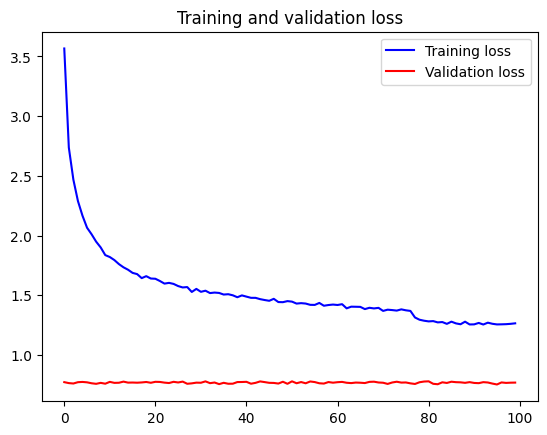

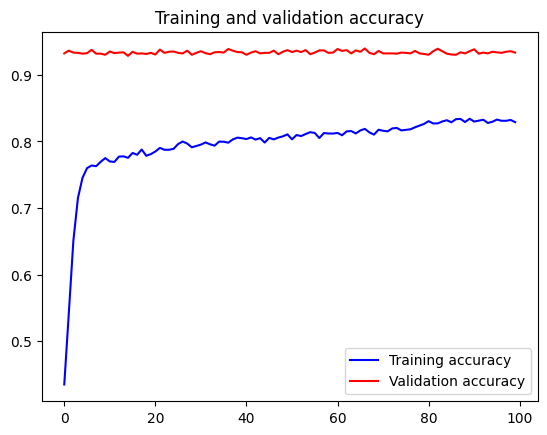

In [48]:
plot_losses(train_loss, test_loss, save_to_file=False)
plot_accuracy(train_acc, test_acc, save_to_file=False)

torch.Size([128])


<Figure size 1000x1000 with 0 Axes>

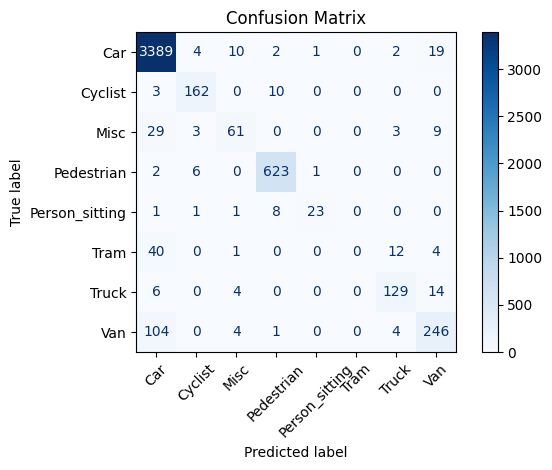

Classification Report:
                precision    recall  f1-score   support

           Car       0.95      0.99      0.97      3427
       Cyclist       0.92      0.93      0.92       175
          Misc       0.75      0.58      0.66       105
    Pedestrian       0.97      0.99      0.98       632
Person_sitting       0.92      0.68      0.78        34
          Tram       0.00      0.00      0.00        57
         Truck       0.86      0.84      0.85       153
           Van       0.84      0.69      0.76       359

      accuracy                           0.94      4942
     macro avg       0.78      0.71      0.74      4942
  weighted avg       0.92      0.94      0.93      4942



/root/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
y_true = []
y_pred = []

new_model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        pos = batch['pos'].to(device)
        labels = batch['label'].to(device) # Chuyển về numpy để lưu trữ

        class_logits, _ = new_model(pos)
        _,predicted = torch.max(class_logits, 1)

        y_true.extend(labels.cpu().tolist())   # convert to list of ints
        y_pred.extend(predicted.cpu().tolist())  # convert to list of ints



cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_to_id.keys()))

# Vẽ confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_to_id.keys())))
